# Behavior cloning 
## on pseudo-driving data-set (multi-modal version) using regressor

## Imports

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [12]:
import sys
sys.path.append('/home/yangz2/projects/bishop1995_notes/modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback
from trainer import Trainer

## Load data

In [13]:
with open('../data/pseudo_driving_dataset_multimodal.json', 'r') as json_f:
    states, actions = map(np.array, json.load(json_f))
    
states = states.reshape(-1, 10 * 40)  # flatten, to be fed into a fully-connected network as 1-d vectors
actions = actions[:,1].reshape(-1, 1)  # only take the delta_y's, since delta_x's are fixed 
# actions need no normalization

print(states.shape, actions.shape)
print(states.min(), states.max(), actions.min(), actions.max())

(226, 400) (226, 1)
0.0 1.0 -10 10


In [14]:
train_ds = TensorDataset(
    torch.from_numpy(states).float(), 
    torch.from_numpy(actions).float()
)
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)  # use a small batch size since our training set is small

## Define neural net regressor

In [15]:
class Regressor(nn.Module):
    
    def __init__(self, input_len, output_len, num_neurons):
        super().__init__()
        
        self.main = nn.Sequential(
            
            # layer 1
            nn.Linear(input_len, num_neurons),
            nn.LeakyReLU(),
            
            # layer 2
            nn.Linear(num_neurons, num_neurons),
            nn.LeakyReLU(),
            
            # layer 3
            nn.Linear(num_neurons, num_neurons),
            nn.LeakyReLU(),
            
            # output layer
            nn.Linear(num_neurons, output_len),
        
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb

In [16]:
def get_model(**kwargs):
    model = Regressor(**kwargs)
    return model, optim.Adam(model.parameters(), lr=10)

## Fine-tune learning rate

Simply pick the learning rate that corresponds to the steepest slope on the plot. No need to be super accurate.

In [17]:
train_again = True  # no need to train again since the model is saved can be loaded below

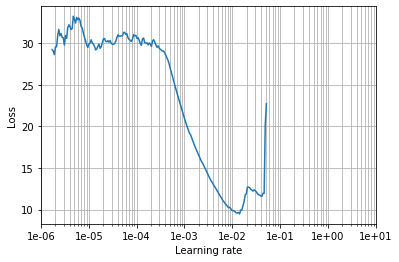

In [18]:
if train_again:
    
    model, opt = get_model(input_len=400, output_len=1, num_neurons=200)
    loss = nn.MSELoss()
    learn = Learner(train_dl, train_dl, model, loss, opt)

    loss_cb = LossCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb])

    trainer = Trainer(learn=learn, cb_handler=cb_handler)

    trainer.find_lr(beta=0.98, final_value=10, num_itr=300)

In [19]:
if train_again:
    trainer.set_lr(1e-3)

## Train neural net

In [20]:
if train_again:
    trainer.train(200)  # take less than 2 minutes since we are using a small dataset and a small network

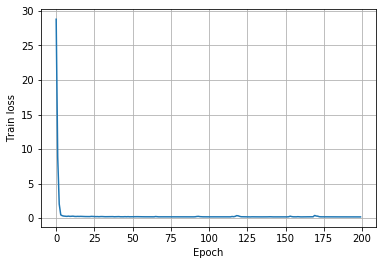

In [21]:
if train_again:
    loss_cb.plot()
    plt.ylabel('Train loss')
    plt.savefig('../results/multimodal_regressor_loss.png')

In [22]:
if train_again:
    trainer.save_as_pth('../results/multimodal_regressor.pth')

In [23]:
trainer.load_from_pth('../results/multimodal_regressor.pth')
model = trainer.learn.model
model = model.eval()

## Analyze results

In [24]:
with open('../data/pseudo_driving_track_multimodal.json', 'r') as json_f:
    track = np.array(json.load(json_f))
    track_vis = track.copy()  # for visualization later, no need to normalize

In [25]:
def get_state_from_coord(x, y):
    return track[x:x+10,y-20:y+20]

Rollout a trajectory in the state space using the policy learned.

In [26]:
x, y = 0, 60
state = get_state_from_coord(x, y)

xs_gen, ys_gen = [x], [y]

for i in range(len(states) // 2):
    
    state_preprocess = torch.from_numpy(state.reshape(1, 400)).float()
    delta_y = model(state_preprocess).detach().numpy()  # delta_y is the action to take in state_preprocess
    
    x, y = int(x + 5), int(y + delta_y)  # take action
    state = get_state_from_coord(x, y)  # observe the new state as a result of taking action
    
    xs_gen.append(x); ys_gen.append(y)

Visualize the trajectory in the state space by highlighting the states visited by the agent.

In [27]:
for x, y in zip(xs_gen, ys_gen):
    track_vis[x, y] = 2

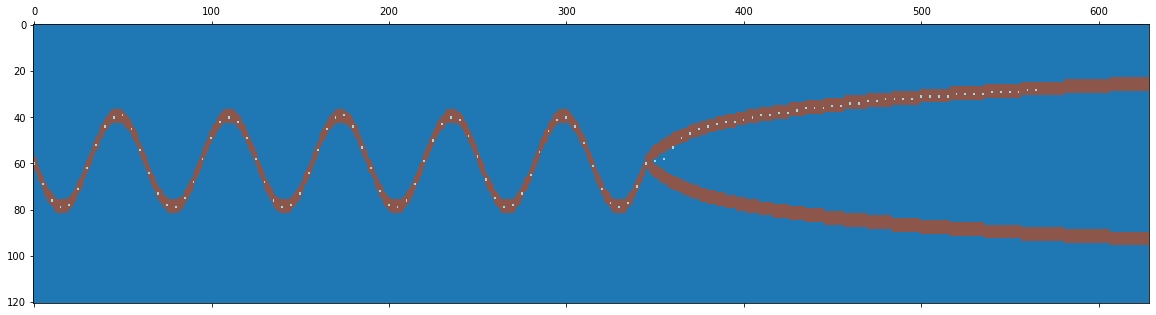

In [28]:
plt.figure(figsize=(20, 5))
plt.matshow(track_vis.T, fignum=1, aspect='auto', cmap='tab20')
plt.savefig('../results/multimodal_regressor_agent_trajectory.png')